# 데이터셋 불러오기
- 데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 사용함
- STL10 dataset은 10개의 label을 가짐

# Study Log
- [1. [논문 구현] PyTorch로 GoogLeNet(2014) 구현하고 학습하기](https://deep-learning-study.tistory.com/523)
    - 학습이 안됨..
- [2. Paperswithcode(bisakhmondal) - GoogLeNet](https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/googlenet.py#L62)
- [3. Paperswithcode(datumbox) - GoogLeNet](https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py)

- 220411  
    - 방법 1로는 학습이 되지 않는 문제 -> 방법 2를 통해 해결 시도
    - train, valid, test 3가지로 split하는 것 구현
    - earlystopping 유무 시의 출력의 차이 비교
    - model을 정의하는 부분에서 softmax값을 반환하던 LeNet-5와 return값에 차이가 있음
        - 이 때문에 같은 model(X)라도 return값이 달라져서 loss_func이 제대로 작동 못하는 중
    - `(2017) DenseNet.ipynb`에서 train_val 코드 정상적으로 작동하니.. 구글넷에도 적용해보자

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
import time
import copy

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# specify the data path
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())
test_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())

# train, valid, test split
from torch.utils.data.dataset import random_split
test_ds, val_ds = random_split(test_ds, [3000, 2000])

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

Files already downloaded and verified
Files already downloaded and verified
8000
2000
3000


In [31]:
# To normalize the dataset, calculate the mean and std
# train
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

# vaild
val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

# test
test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_ds]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_ds]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])

test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)
print(test_meanR, test_meanG, test_meanB)

0.44723064 0.4396425 0.40495726
0.44997376 0.44296858 0.4093409
0.44453523 0.43770406 0.40485018


In [32]:
# define the image transformation
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],
                                             [train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([val_meanR, val_meanG, val_meanB],
                                             [val_stdR, val_stdG, val_stdB]),
])

test_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([test_meanR, test_meanG, test_meanB],
                                             [test_stdR, test_stdG, test_stdB]),
])

# apply transforamtion
train_ds.transform = train_transformation
val_ds.transform = val_transformation
test_ds.tramsform = test_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [2732 2607 1653 3264]
torch.Size([3, 228, 906])


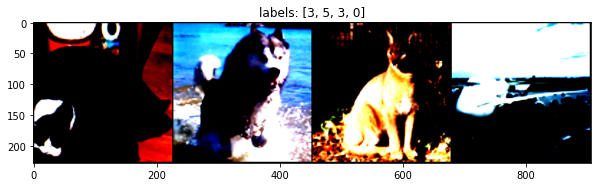

In [8]:
# display sample images
def show(img, y=None, color=True):
#     npimg = img.numpy()
    npimg = img.detach().numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

# 모델 구축하기

In [9]:
class GoogLeNet(nn.Module):
    def __init__(self,aux_logits=True, num_classes=10, init_weights=True):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # conv_block takes in_channels, out_channels, kernel_size, stride, padding
        # Inception block takes out1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, 1)
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, 2, 1)
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

        # auxiliary classifier

        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

        # auxiliary classifier

        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, 2, 1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, 1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = x.view(x.shape[0], -1)

        x = self.dropout(x)
        x = self.fc1(x)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x 

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_layer(x)


class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값을 묶어줍니다. 
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
        return x

# auxiliary classifier의 loss는 0.3이 곱해지고, 최종 loss에 추가합니다. 정규화 효과가 있습니다. 
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GoogLeNet(aux_logits=True, num_classes=10, init_weights=True).to(device)
print(model)

cpu
GoogLeNet(
  (conv1): conv_block(
    (conv_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (conv_layer): Sequential(
      (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (conv_layer): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (branch2): Sequentia

In [11]:
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output)

(tensor([[ 0.3204, -0.0240, -0.1539, -0.0140,  0.1078, -0.1985, -0.2720, -0.5838,
         -0.2458, -0.0840],
        [ 0.1438, -0.1162, -0.0227,  0.0169,  0.0453, -0.0189, -0.1845, -0.6054,
          0.0084, -0.3263],
        [ 0.2981,  0.1492,  0.0453,  0.1308, -0.1443, -0.0279, -0.0062, -0.3835,
          0.0914, -0.0421]], grad_fn=<AddmmBackward0>), tensor([[ 0.0107,  0.0578, -0.0115, -0.0978,  0.0288, -0.1122, -0.0949, -0.0950,
          0.0196, -0.0920],
        [-0.0157, -0.0446, -0.0462, -0.0156, -0.1488, -0.2007,  0.0879, -0.2064,
         -0.0219, -0.1782],
        [ 0.2249,  0.0294, -0.0119, -0.0044, -0.0655, -0.0106, -0.1153, -0.0626,
         -0.0315, -0.0322]], grad_fn=<AddmmBackward0>), tensor([[-0.1532, -0.0652, -0.0593, -0.1354,  0.0782, -0.0806,  0.0989,  0.1646,
         -0.0184, -0.0024],
        [-0.1233, -0.0056,  0.0398, -0.0893,  0.0755, -0.2080,  0.1170,  0.0602,
         -0.2245, -0.0724],
        [-0.0557, -0.0732, -0.1526, -0.1176,  0.1669,  0.0830,  0.1449,

In [12]:
summary(model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
        conv_block-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
       BatchNorm2d-7          [-1, 192, 56, 56]             384
              ReLU-8          [-1, 192, 56, 56]               0
        conv_block-9          [-1, 192, 56, 56]               0
        MaxPool2d-10          [-1, 192, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          12,352
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             ReLU-13           [-1, 64, 28, 28]               0
       conv_block-14           [-1, 64,

# 학습하기

## 방법 1
- `./original/(2014) GoogLeNet.ipynb`에 있는 방법으로 하면 error 발생

In [10]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']



def metric_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects



def loss_batch(loss_func, outputs, target, opt=None):
    if np.shape(outputs)[0] == 3:
        output, aux1, aux2 = outputs

        output_loss = loss_func(output, target)
        aux1_loss = loss_func(aux1, target)
        aux2_loss = loss_func(aux2, target)

        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        metric_b = metric_batch(output,target)

    else:
        loss = loss_func(outputs, target)
        metric_b = metric_batch(outputs, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b



def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output= model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric



def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')
    
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        lr_scheduler.step()

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' 
              %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [11]:
# definc the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [12]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr=0.001


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

## 방법 2
- [CNN, data augmentation X (pytorch, test acc: 74.2)](https://dacon.io/competitions/official/235874/codeshare/4610?page=1&dtype=recent)에서 제시한 코드를 참고해서 구현해보기

In [16]:
class EarlyStopping:
    ''' 주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지'''
    
    def __init__(self, patience = 7, verbose = False, delta = 0, path='checkpoint.pt'):
        '''
        Args:
        patience(int) : validation loss가 개선된 후 기다리는 시간 (Default : 7)
        verbose(bool) : True일 경우 각 validation loss의 개선 사항 메시지 출력 (Default : False)
        delta(float) : 개선되었다고 인정되는 monitored quantity의 최소 변화 (Default : 0)
        path (str) : checkpoint 저장 경로 (Default : 'checkpoint.pt')
        '''
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
    
    def _call_(self, val_loss, model):
        score -= val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.check_point(val_loss, model)
            
        elif score < self.best_score + self.delta :
            self.counter += 1
            print(f'EarlyStopping counter : {self.counter} out of {self.patience}')
            
            # 지정한 patience 횟수를 거쳤음에도 val_loss가 개선되지 않은 경우 earlystop 종료
            if self.counter >= self.patience:
                self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model)
                self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장함'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss : .6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [35]:
type(val_dl)
type(train_dl)

torch.utils.data.dataloader.DataLoader

torch.utils.data.dataloader.DataLoader

In [38]:
def fit(model, patience, loss_fn, optimizer, n_epochs):
    train_losses = []
    val_losses = []
    avg_train_loss = []
    avg_valid_loss = []
    
    early_stopping = EarlyStopping(patience = patience, verbose = True)
    
    for epoch in range(1, n_epochs+1):
        model.train()
        for batch, (X, y) in enumerate(train_dl):
            X = X.to(device)
            y = y.to(device)
            
            # Compute prediction and loss
            pred = model(X)
            loss = loss_func(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
    model.eval()
    for data, target in val_dl:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        loss = loss_func(output, target)
        
        val_losses.append(loss.item())
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        avg_train_loss.append(train_loss)
        avg_val_loss.append(val_loss)

        epoch_len = len(str(n_epochs)) # ??

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' + 
                     f'train_loss: {train_loss:.5f} ' +
                     f'val_loss: {val_loss:.5f}')

        print(print_msg)

        train_losses = []
        valid_losses = []

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('checkpoint.pt'))
    return  model, avg_train_losses, avg_valid_losses

learning_rate = 0.001
batch_size = 128
epochs = 100
# loss_func = nn.CrossEntropyLoss().to(device)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
patience = 20
n_epochs = 100

model, train_loss, val_loss = fit(model, patience, loss_func, optimizer, n_epochs)

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

## 방법 3
- `(2017) DenseNet.ipynb`의 학습 코드 참고

In [20]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [21]:
# define the training parameters
params_train = {
    'num_epochs':3,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [22]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/2, current lr= 0.01


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple